In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import struct

In [ ]:
# input path
path_train_imgs = '1/train-images.idx3-ubyte'
path_train_labels = '1/train-labels.idx1-ubyte'
path_test_imgs = '1/t10k-images.idx3-ubyte'
path_test_labels = '1/t10k-labels.idx1-ubyte'
# output path
out_train_data = '1/train_data.csv'
out_train_label = '1/train_label.csv'
out_test_data = '1/test_data.csv'
out_test_label = '1/test_label.csv'

In [ ]:
# convert data from ubyte to csv
def idx1_to_df(idx1_path):
    with open(idx1_path, 'rb') as f:
        _, count = struct.unpack('>II', f.read(8))
        labels = list(f.read())
    return pd.DataFrame({'index': range(count), 'label': labels})

def idx3_to_df(idx3_path):
    with open(idx3_path, 'rb') as f:
        _, count, rows, cols = struct.unpack('>IIII', f.read(16))
        raw = f.read()
    pixels = [
        list(raw[i*rows*cols : (i+1)*rows*cols])
        for i in range(count)
    ]
    df = pd.DataFrame(pixels, columns=[f'pixel{j}' for j in range(rows*cols)])
    df.insert(0, 'index', range(count))
    return df

df_train_lbl = idx1_to_df(path_train_labels)
df_test_lbl  = idx1_to_df(path_test_labels)

df_train_lbl.to_csv(out_train_label,index=False)
df_test_lbl.to_csv(out_test_label,index=False)
df_train_data = idx3_to_df(path_train_imgs)
df_test_data = idx3_to_df(path_test_imgs)
df_train_data.to_csv(out_train_data,index=False)
df_test_data.to_csv(out_test_data,index=False)

# print info/size
print("train_data.csv", df_train_data.shape)
print("test_data.csv", df_test_data.shape)
print("train_label.csv", df_train_lbl.shape)
print("test_label.csv", df_test_lbl.shape)

train_data.csv (60000, 785)
test_data.csv (10000, 785)
train_label.csv (60000, 2)
test_label.csv (10000, 2)


In [ ]:
# load data
np.random.seed(42)
train_data = pd.read_csv("1/train_data.csv")
train_label = pd.read_csv("1/train_label.csv")
test_data = pd.read_csv("1/test_data.csv")
test_label = pd.read_csv("1/test_label.csv")

In [ ]:
# Drop label column, scale pixels to [0,1] (one hot encoding normalization)
X_all = train_data.drop(columns=['index']).values.astype(np.float32) / 255.0
y_all = train_label['label'].values.astype(np.int32)

# train val split: 50 000 train / 10 000 val
X_train, y_train = X_all[:50000], y_all[:50000]
X_val, y_val = X_all[50000:], y_all[50000:]

# Test set
X_test = test_data.drop(columns=['index']).values.astype(np.float32) / 255.0
y_test = test_label['label'].values.astype(np.int32)

In [ ]:
# initialize weights and bias
input_dim = X_train.shape[1]
hidden_dim = 10
output_dim = 10
W1 = np.random.randn(input_dim,hidden_dim)
b1 = np.zeros((1,hidden_dim))
W2 = np.random.randn(hidden_dim,hidden_dim) 
b2 = np.zeros((1,hidden_dim))
W3 = np.random.randn(hidden_dim,hidden_dim) 
b3 = np.zeros((1,hidden_dim))
W4 = np.random.randn(hidden_dim,output_dim)  
b4 = np.zeros((1,output_dim))

In [ ]:
# activation function
def relu(Z):
    return np.maximum(0, Z)

# softmax to convert data to probability
def softmax(Z):
    eZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return eZ / np.sum(eZ, axis=1, keepdims=True)

# loss function
def cross_entropy_loss(A, y):
    m = y.shape[0]
    log_probs = -np.log(A[np.arange(m), y] + 1e-9)
    return np.mean(log_probs)

# forward pass value
def forward(X):
    Z1 = X.dot(W1) + b1
    A1 = relu(Z1)
    Z2 = A1.dot(W2) + b2
    A2 = relu(Z2)
    Z3 = A2.dot(W3) + b3
    A3 = relu(Z3)
    Z4 = A3.dot(W4) + b4
    A4 = softmax(Z4)
    return Z1, A1, Z2, A2, Z3, A3, Z4, A4

# back-propagation
def backward(X, y, Z1, A1, Z2, A2, Z3, A3, A4):
    m = y.shape[0]
    # onehot encode
    Y = np.zeros_like(A4)
    Y[np.arange(m), y] = 1

    # output layer
    dZ4 = A4 - Y
    dW4 = (A3.T @ dZ4) / m
    db4 = dZ4.sum(axis=0, keepdims=True) / m

    # layer 3
    dA3 = dZ4 @ W4.T
    dZ3 = dA3 * (Z3 > 0)
    dW3 = (A2.T @ dZ3) / m
    db3 = dZ3.sum(axis=0, keepdims=True) / m

    # layer 2
    dA2 = dZ3 @ W3.T
    dZ2 = dA2 * (Z2 > 0)
    dW2 = (A1.T @ dZ2) / m
    db2 = dZ2.sum(axis=0, keepdims=True) / m

    # layer 1
    dA1 = dZ2 @ W2.T
    dZ1 = dA1 * (Z1 > 0)
    dW1 = (X.T @ dZ1) / m
    db1 = dZ1.sum(axis=0, keepdims=True) / m

    return dW1, db1, dW2, db2, dW3, db3, dW4, db4

In [ ]:
# train parameter setup
epochs = 50
batch_size = 10
learning_rate = 0.001 
np.random.seed(42)

In [ ]:
loss_history = []

for epoch in range(1, epochs+1):

    # shuffle random images from the training model
    perm = np.random.permutation(len(X_train))
    X_shuf, y_shuf = X_train[perm], y_train[perm]

    for i in range(0, len(X_train), batch_size):

        # shuffled data, get batches from it
        Xb = X_shuf[i:i+batch_size]
        yb = y_shuf[i:i+batch_size]

        # forward pass
        Z1, A1, Z2, A2, Z3, A3, Z4, A4 = forward(Xb)

        # loss calculation
        loss = cross_entropy_loss(A4, yb)
        loss_history.append(loss)

        # backward
        dW1, db1, dW2, db2, dW3, db3, dW4, db4 = backward(Xb, yb, Z1, A1, Z2, A2, Z3, A3, A4)

        # back-propagate update
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        W3 -= learning_rate * dW3
        b3 -= learning_rate * db3
        W4 -= learning_rate * dW4
        b4 -= learning_rate * db4

    # validation eval
    _, _, _, _, _, _, _, A4_val = forward(X_val)
    val_acc = np.mean(np.argmax(A4_val, axis=1) == y_val)
    print(f"Epoch {epoch}/{epochs} — Val Acc: {val_acc*100:.2f}% — Loss: {loss:.4f}")

# test eval
_, _, _, _, _, _, _, A4_test = forward(X_test)
test_acc = np.mean(np.argmax(A4_test, axis=1) == y_test)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")

Epoch 1/50 — Val Acc: 30.03% — Loss: 1.7347
Epoch 2/50 — Val Acc: 33.41% — Loss: 2.0112
Epoch 3/50 — Val Acc: 35.98% — Loss: 1.7637
Epoch 4/50 — Val Acc: 39.31% — Loss: 2.7690
Epoch 5/50 — Val Acc: 39.84% — Loss: 1.6699
Epoch 6/50 — Val Acc: 41.94% — Loss: 1.1704
Epoch 7/50 — Val Acc: 43.51% — Loss: 1.4856
Epoch 8/50 — Val Acc: 44.91% — Loss: 1.7012
Epoch 9/50 — Val Acc: 45.89% — Loss: 1.3130
Epoch 10/50 — Val Acc: 46.42% — Loss: 1.8127
Epoch 11/50 — Val Acc: 48.18% — Loss: 0.8785
Epoch 12/50 — Val Acc: 49.65% — Loss: 1.9939
Epoch 13/50 — Val Acc: 50.81% — Loss: 0.7167
Epoch 14/50 — Val Acc: 51.11% — Loss: 0.9233
Epoch 15/50 — Val Acc: 51.79% — Loss: 1.2479
Epoch 16/50 — Val Acc: 53.79% — Loss: 0.8666
Epoch 17/50 — Val Acc: 53.84% — Loss: 1.0414
Epoch 18/50 — Val Acc: 55.50% — Loss: 0.8878
Epoch 19/50 — Val Acc: 56.33% — Loss: 1.6658
Epoch 20/50 — Val Acc: 56.21% — Loss: 0.6366
Epoch 21/50 — Val Acc: 57.70% — Loss: 1.6908
Epoch 22/50 — Val Acc: 58.82% — Loss: 1.1067
Epoch 23/50 — Val A

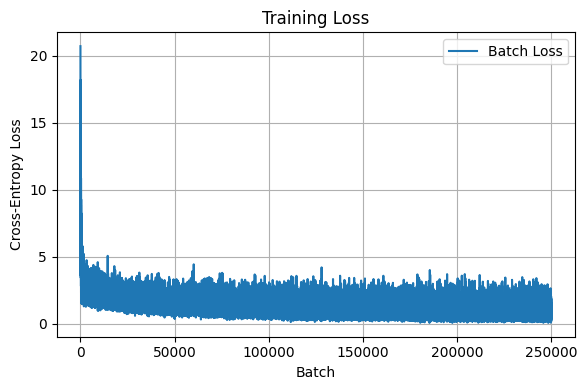

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(loss_history, label='Batch Loss')
plt.xlabel('Batch'); plt.ylabel('Cross‑Entropy Loss')
plt.title('Training Loss')
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

Test Accuracy: 68.31%
Number of misclassified examples: 3169 / 10000


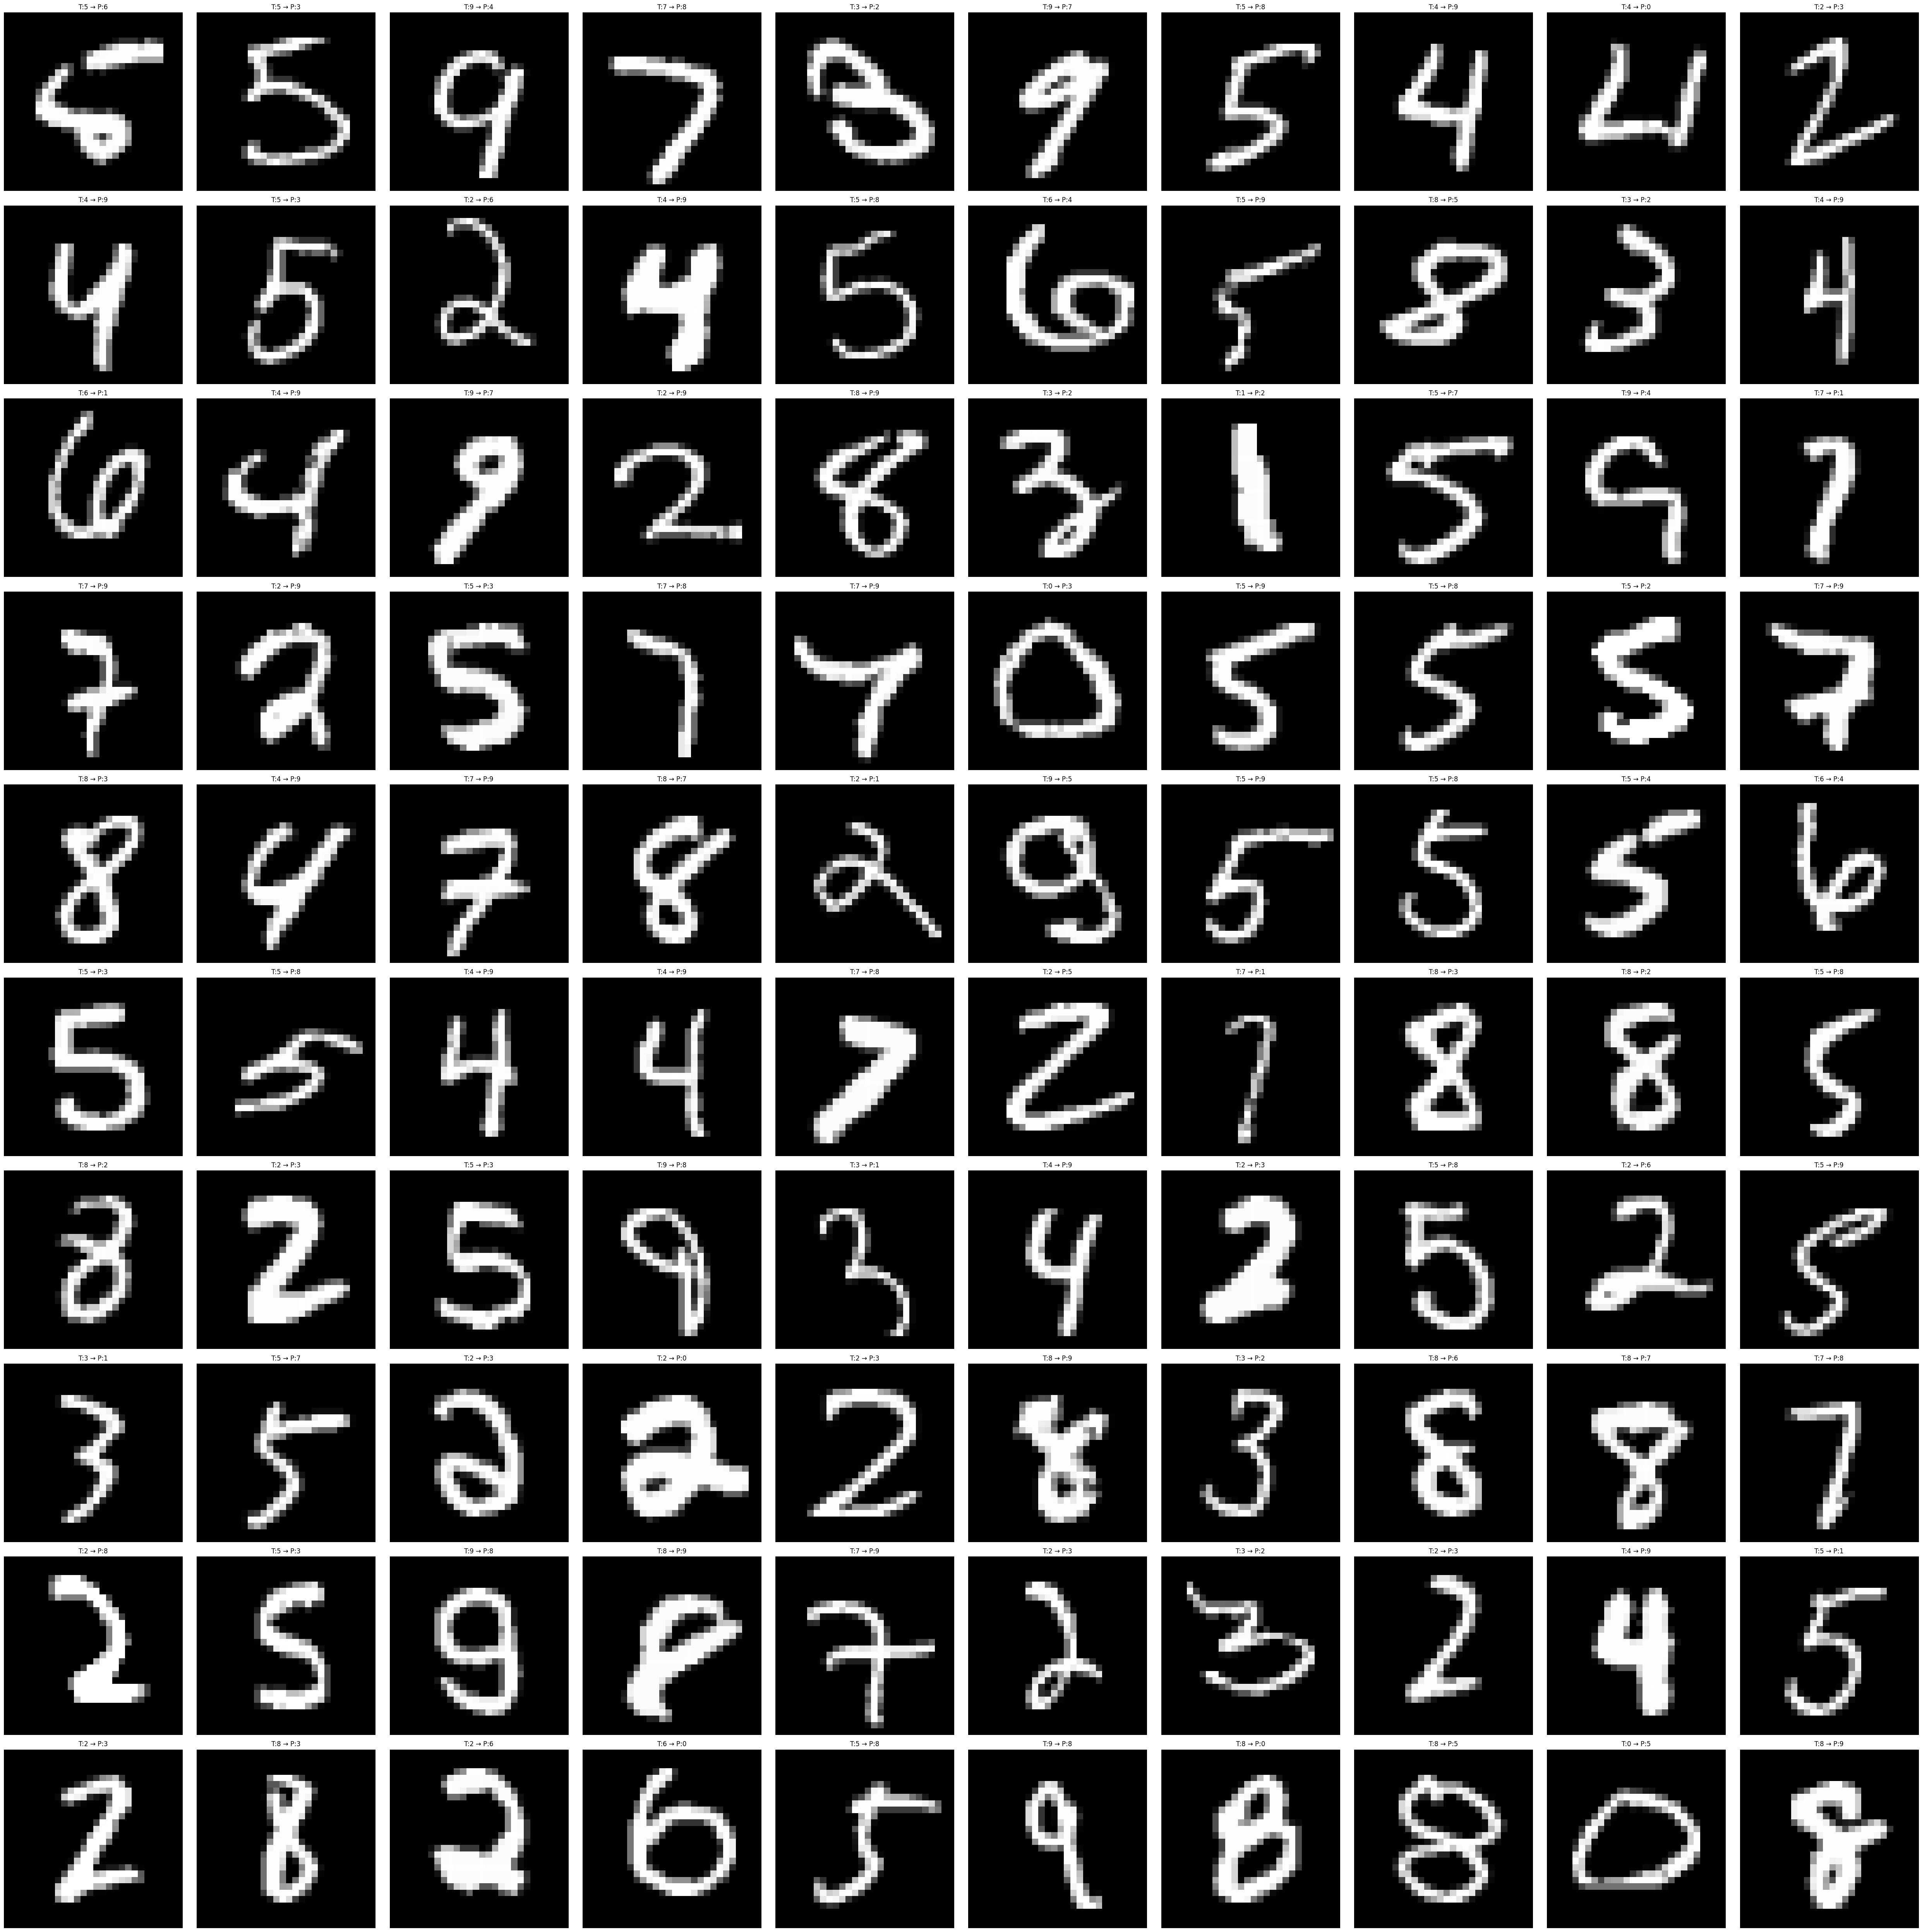

In [ ]:
df_test   = pd.read_csv('1/test_data.csv')
df_labels = pd.read_csv('1/test_label.csv')

# one hot encoding
X_test = df_test.drop(columns=['index']).values.astype(np.float32) / 255.0
y_test = df_labels['label'].values.astype(int)

# forward
Z1, A1, Z2, A2, Z3, A3, Z4, A4 = forward(X_test)

# A4 is the softmax probabilities
preds = np.argmax(A4, axis=1)

# accuracy
acc = np.mean(preds == y_test)
print(f"Test Accuracy: {acc * 100:.2f}%")

# show misclassification
mis_idx = np.where(preds != y_test)[0]
print(f"Number of misclassified examples: {len(mis_idx)} / {len(y_test)}")

n_show = 100
plt.figure(figsize=(50, 50))
for i, idx in enumerate(mis_idx[:n_show]):
    img = (X_test[idx].reshape(28, 28) * 255).astype(np.uint8)
    ax = plt.subplot(10, 10, i+1)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"T:{y_test[idx]} → P:{preds[idx]}")
    ax.axis('off')
plt.tight_layout()
plt.show()